In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import os
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
tf.random.set_seed(123)
data = pd.read_excel("IMPORTACION-VOLUMEN-2024-05.xlsx", index_col="Fecha", parse_dates=["Fecha"], date_format="%Y-%m-%d ", skiprows=6, skipfooter=3)

import_data = data['Gasolina regular'].to_frame()
import_data

,Gasolina regular
Fecha,
2001-01-01 00:00:00,177776.50
2001-02-01 00:00:00,123115.99
2001-03-01 00:00:00,161726.42
2001-04-01 00:00:00,127338.74
2001-05-01 00:00:00,168730.19
...,...
2024-01-01 00:00:00,914133.32
2024-02-01 00:00:00,740662.25
2024-03-01 00:00:00,838270.93


In [4]:
import matplotlib.dates as mdates

# Assuming consume_data is already loaded

# Ensure the index is a DatetimeIndex
if not isinstance(import_data.index, pd.DatetimeIndex):
    import_data.index = pd.to_datetime(import_data.index)

# Group the data by year and sum the values
import_data_yearly = import_data.resample('Y').sum()

/var/folders/nh/qxcg2qs54dq8v4tnbxqzpm7w0000gn/T/ipykernel_2779/2232612997.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  import_data_yearly = import_data.resample('Y').sum()


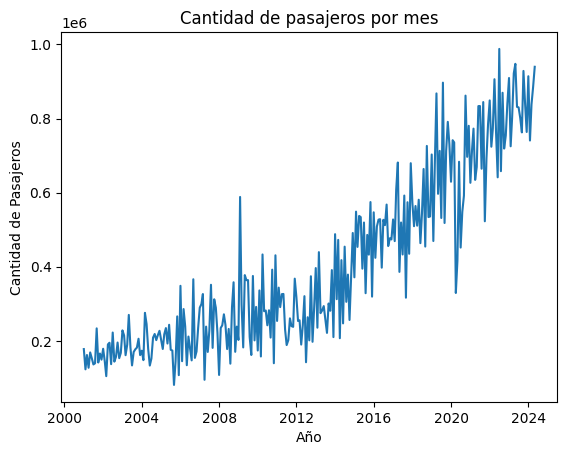

In [5]:
plt.plot(import_data)
plt.gca().set(title="Cantidad de pasajeros por mes", xlabel="Año", ylabel="Cantidad de Pasajeros")
plt.show()

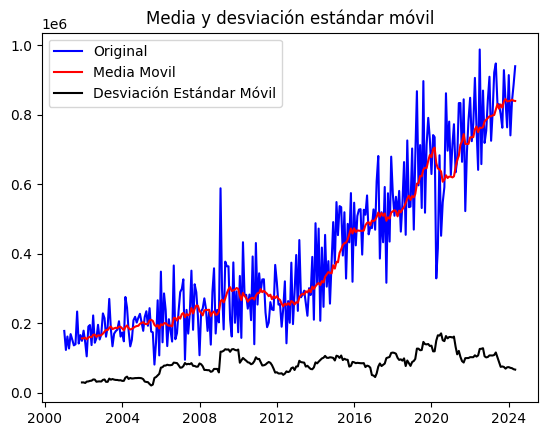

In [6]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = import_data.rolling(window=12).mean()
deMovil = import_data.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(import_data, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

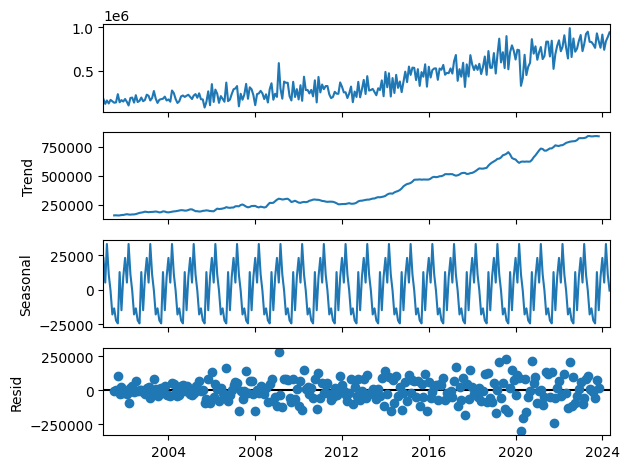

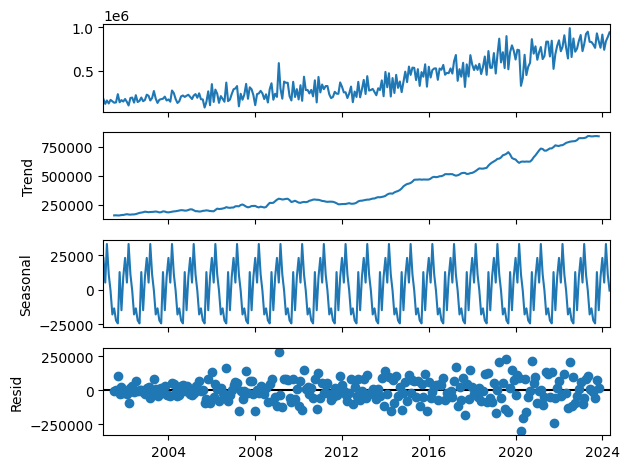

In [7]:
descomposicion = seasonal_decompose(import_data, model='additive', period=12)
descomposicion.plot()

In [8]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(import_data, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.828829
p-value                        0.992088
# de retardos usados           9.000000
# de observaciones usadas    271.000000
Critical Value (1%)           -3.454713
Critical Value (5%)           -2.872265
Critical Value (10%)          -2.572485
dtype: float64


In [9]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
import_data_diff = import_data.diff()
import_data_diff.fillna(0,inplace=True)
dfTest = adfuller(import_data_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -1.012772e+01
p-value                      9.088501e-18
# de retardos usados         8.000000e+00
# de observaciones usadas    2.720000e+02
Critical Value (1%)         -3.454622e+00
Critical Value (5%)         -2.872225e+00
Critical Value (10%)        -2.572464e+00
dtype: float64


In [10]:
scaler = StandardScaler()
import_data_scaled = scaler.fit_transform(import_data_diff) 
import_data_scaled[1:7]


array([[-0.4269126 ],
       [ 0.26713085],
       [-0.27605935],
       [ 0.28782485],
       [-0.13797697],
       [-0.14369818]])

In [11]:
entrenamiento = round(0.6*len(import_data_scaled))
val_prueba = round(0.2*len(import_data_scaled))
test = import_data_scaled[(entrenamiento+val_prueba)-1:]
validation = import_data_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = import_data_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

57

In [12]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)



In [13]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

56

In [14]:
lote = 1
unidades = 1
paso = 1
caracteristicas = 1 #es univariada

In [15]:
from keras import regularizers

modelo1 = Sequential()

inputs = keras.layers.Input((paso, caracteristicas))
lstm_out = keras.layers.LSTM(lote, activation='tanh', kernel_regularizer=regularizers.l2(0.001))(inputs)
outputs = keras.layers.Dense(3)(lstm_out)
outputs = keras.layers.Dense(1)(outputs)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
modelo2 = Sequential()

inputs = keras.layers.Input((paso, caracteristicas))
lstm_out = keras.layers.LSTM(lote, activation='relu', kernel_regularizer=regularizers.l1(0.001))(inputs)
outputs = keras.layers.Dense(5)(lstm_out)
outputs = keras.layers.Dense(2)(outputs)
outputs = keras.layers.Dense(1)(outputs)

modelo2 = keras.Model(inputs=inputs, outputs=outputs)
modelo2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
modelo1.compile(loss='mean_squared_error',optimizer="adam")
modelo2.compile(loss='mean_squared_error',optimizer="rmsprop")

In [18]:
epocas = 100
history1 = modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

history2 = modelo2.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = True,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4481 - val_loss: 1.6422
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 0.4139 - val_loss: 1.5607
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 0.3968 - val_loss: 1.5031
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 0.3841 - val_loss: 1.4466
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.3705 - val_loss: 1.3692
Epoch 6/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.3513 - val_loss: 1.2577
Epoch 7/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 0.3263 - val_loss: 1.1256
Epoch 8/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 0.3022 - val_loss: 1.0037
Epoch 9/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 0.2859 - val_loss: 0.9114
Epoch 10/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 0.2785 - val_loss: 0.8496
Epoch 11/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 0.2768 - val_loss: 0.8104
Epoch 12/100
169/169 

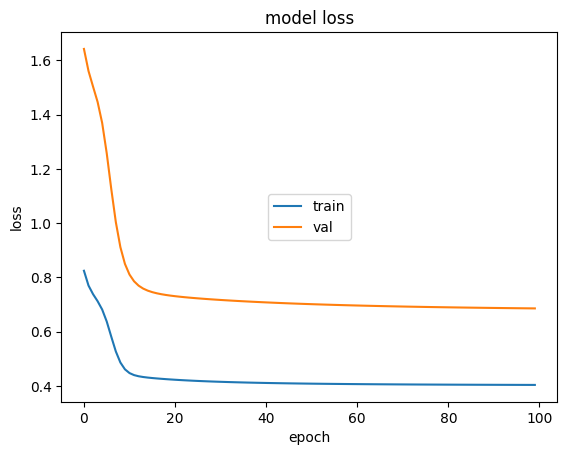

In [19]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

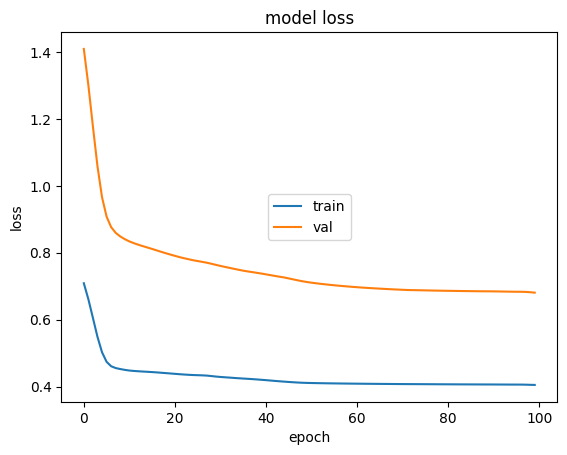

In [20]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [21]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.3153
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6178 
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1321


1.057830572128296

In [22]:
print("Pérdida en Entrenamiento")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 0.3105
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6154 
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1284 


1.058875322341919

In [23]:
medianLoss1 = np.median(history1.history['val_loss'])
medianLoss2 = np.median(history2.history['val_loss'])

modelo = modelo1

if medianLoss1 < medianLoss2:
    print('LossMedia 1: ', medianLoss1)
    print('LossMedia 2: ', medianLoss2)
    print("El modelo 1 es mejor")
else:
    print('LossMedia 1: ', medianLoss1)
    print('LossMedia 2: ', medianLoss2)
    print("El modelo 2 es mejor")
    modelo = modelo2

LossMedia 1:  0.7014546990394592
LossMedia 2:  0.711529016494751
El modelo 1 es mejor


In [24]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
            # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion

In [25]:
prediccion_val = prediccion_fun(x_val,modelo, 1,scaler,dif=True,dif_cant=1, Series = import_data.values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo, 1,scaler,dif=True,dif_cant=1, Series = import_data.values , n=entrenamiento+val_prueba)

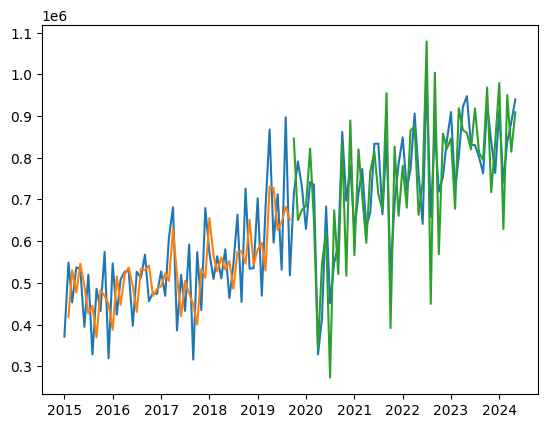

In [26]:
df_val = pd.DataFrame(prediccion_val,index=import_data[(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test,index=import_data[entrenamiento+len(df_val):len(import_data)].index)


plt.plot(import_data['2015':])
plt.plot(df_val)
plt.plot(df_test)

In [27]:
# Calculate metrics for validation predictions
mae_val = mean_absolute_error(import_data[entrenamiento:entrenamiento+val_prueba], prediccion_val)
mse_val = mean_squared_error(import_data[entrenamiento:entrenamiento+val_prueba], prediccion_val)
r2_val = r2_score(import_data[entrenamiento:entrenamiento+val_prueba], prediccion_val)

# Calculate metrics for test predictions
mae_test = mean_absolute_error(import_data[entrenamiento+len(df_val):len(import_data)], prediccion_test)
mse_test = mean_squared_error(import_data[entrenamiento+len(df_val):len(import_data)], prediccion_test)
r2_test = r2_score(import_data[entrenamiento+len(df_val):len(import_data)], prediccion_test)

# Print the results
print(f"Validation MAE: {mae_val}, MSE: {mse_val}, R²: {r2_val}")
print(f"Test MAE: {mae_test}, MSE: {mse_test}, R²: {r2_test}")

Validation MAE: 90295.99696568081, MSE: 10470650650.605835, R²: 0.19186075070842246
Test MAE: 84674.03287179129, MSE: 9275437347.163532, R²: 0.472238265812305


In [28]:
print("Mean Absolute Error: ", mae_test)
print("Mean Squared Error: ", mse_test)
print("Root Mean Squared Error: ", r2_test)

Mean Absolute Error:  84674.03287179129
Mean Squared Error:  9275437347.163532
Root Mean Squared Error:  0.472238265812305
